In [1]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

print(device)

cuda


#### Выборки

In [3]:
train_path=os.path.abspath('train_list')
test_path=os.path.abspath('test_list')
val_path=os.path.abspath('val_list')


df = pd.read_csv('annotations.csv', sep = ',', header=None)

df = df.drop(df.index[0])
df.drop(0, axis=1, inplace=True)
df.rename(columns={1: 'full_path', 2: 'img_class'}, inplace=True)
df.reset_index(inplace=True)
print(df)


if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)

if not os.path.isdir(val_path):
    os.mkdir(val_path)

def load_train(df: pd.core.frame.DataFrame, path: str, i: int) -> None:  
    '''
    Загружает  изображение из датафрейма по заданному пути 
    Parameters
        df(pd.core.frame.DataFrame): 
         датафрейм изображений 
        path(str): 
         путь до изображения
        i(int): 
         номер изображения 
    '''  
   
    
    image_path = os.path.abspath(os.path.join(*df.full_path[i].split("\\")))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{df.img_class[i]}.{i}.jpg'), image)

def load_val(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    ''' 
    Загружает  изображение из датафрейма по заданному пути 
    Parameters
        df(pd.core.frame.DataFrame): 
         датафрейм изображений 
        path(str): 
         путь до изображения
        i(int): 
         номер изображения 
    '''  
 
    image_path = os.path.join(*df.full_path[i].split("\\"))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(*path.split("/"), f'{i}.jpg'), image)

def load_test(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    '''
    Загружает  изображение из датафрейма по заданному пути 
    Parameters
        df(pd.core.frame.DataFrame): 
         датафрейм изображений 
        path(str): 
         путь до изображения
        i(int): 
         номер изображения 
    '''
 
    image_path = os.path.join(*df.full_path[i].split("\\"))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)


for i in range(800):
    load_train(df, train_path, i)
for i in range(800,900):
    load_test(df,test_path,i)
for i in range(1800,1900):
    load_test(df,test_path,i)
for i in range(900,1000):
    load_val(df,val_path,i)
for i in range(1900,1999):
    load_val(df,val_path,i)

train_list = glob.glob(os.path.join(train_path,'*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))

train_list, val_list = train_test_split(train_list, test_size=0.1)

      index                    full_path   img_class
0         1  dataset\brown bear\0001.jpg  brown bear
1         2  dataset\brown bear\0002.jpg  brown bear
2         3  dataset\brown bear\0003.jpg  brown bear
3         4  dataset\brown bear\0004.jpg  brown bear
4         5  dataset\brown bear\0005.jpg  brown bear
...     ...                          ...         ...
1994   1995  dataset\polar bear\0995.jpg  polar bear
1995   1996  dataset\polar bear\0996.jpg  polar bear
1996   1997  dataset\polar bear\0997.jpg  polar bear
1997   1998  dataset\polar bear\0998.jpg  polar bear
1998   1999  dataset\polar bear\0999.jpg  polar bear

[1999 rows x 3 columns]


#### Проверка

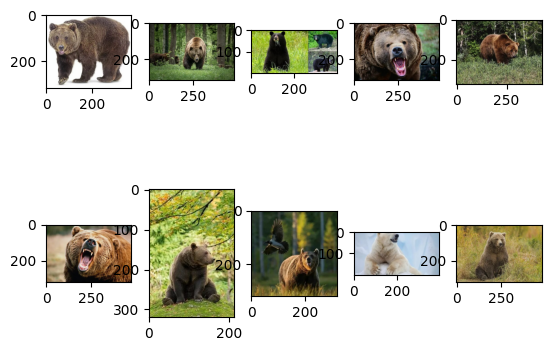

In [4]:
random_idx = np.random.randint(1,200,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = cv2.imread(train_list[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i+=1

plt.show()

In [5]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [8]:
from PIL import Image
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'polar bear':
            label=1
        elif label == 'brown bear':
            label=0
            
        return img_transformed,label

In [9]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

#### Проверка

In [10]:
print(train_data[1])
print(val_data[0][1])

(tensor([[[0.4627, 0.4627, 0.4627,  ..., 0.3647, 0.3647, 0.3647],
         [0.4627, 0.4627, 0.4627,  ..., 0.3647, 0.3647, 0.3647],
         [0.4627, 0.4627, 0.4627,  ..., 0.3647, 0.3647, 0.3647],
         ...,
         [0.3255, 0.3255, 0.3255,  ..., 0.3137, 0.2824, 0.2824],
         [0.3294, 0.3294, 0.3294,  ..., 0.3020, 0.2706, 0.2706],
         [0.3294, 0.3294, 0.3294,  ..., 0.3020, 0.2706, 0.2706]],

        [[0.5804, 0.5804, 0.5843,  ..., 0.4392, 0.4392, 0.4392],
         [0.5804, 0.5804, 0.5843,  ..., 0.4392, 0.4392, 0.4392],
         [0.5804, 0.5804, 0.5843,  ..., 0.4392, 0.4392, 0.4392],
         ...,
         [0.4353, 0.4353, 0.4353,  ..., 0.2980, 0.2706, 0.2706],
         [0.4392, 0.4392, 0.4392,  ..., 0.2902, 0.2588, 0.2588],
         [0.4392, 0.4392, 0.4392,  ..., 0.2902, 0.2588, 0.2588]],

        [[0.3451, 0.3451, 0.3490,  ..., 0.2627, 0.2627, 0.2627],
         [0.3451, 0.3451, 0.3490,  ..., 0.2627, 0.2627, 0.2627],
         [0.3451, 0.3451, 0.3490,  ..., 0.2667, 0.2667, 0

#### Обучение

In [11]:
lr = 0.001 
batch_size = 10 
epochs = 10 
def create_loaders():
    train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)
    return (train_loader, test_loader, val_loader)

train_loader, test_loader, val_loader = create_loaders()
print(len(train_data), len(train_loader))
print(len(val_data), len(val_loader))

720 72
80 8
